## Stock Prediction Playground
**Author: Anthony Tian**

In [49]:
print(os.path.abspath("JPMStockPredictor.ipynb"))  # Replace with actual filename

/Users/showhq/AI Stock Prediction Playground/JPMStockPredictor.ipynb


In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
# past 5 years of JPM data
jpm = yf.download('JPM', start="2014-01-01", end="2024-01-01")
jpm.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,JPM,JPM,JPM,JPM,JPM
Date,,,,,
2014-01-02,43.062962,43.277500,42.885414,43.136942,15627600
2014-01-03,43.395855,43.610394,43.062951,43.122135,14214100
2014-01-06,43.647385,43.995085,43.521622,43.765750,17550700
2014-01-07,43.144333,43.965496,42.988978,43.861926,17851200
2014-01-08,43.551216,43.580808,43.129538,43.307088,14687400


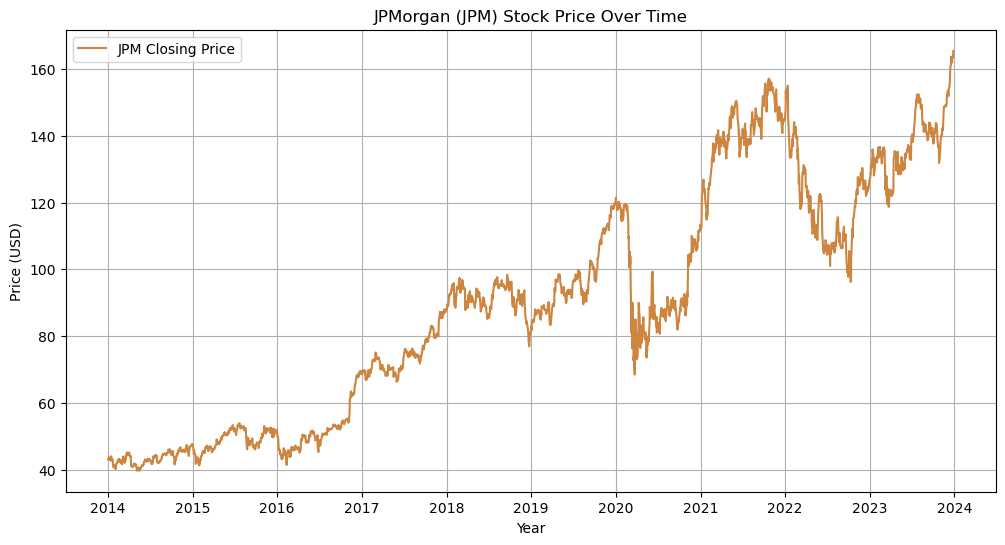

In [5]:
# Plot Closing Prices
plt.figure(figsize=(12,6))
plt.plot(jpm['Close'], label='JPM Closing Price', color='peru')
plt.title('JPMorgan (JPM) Stock Price Over Time')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

**Find trends: moving averages, day-to-day return changes**

SMA_50: 50 day simple moving average

SMA_200: 200 day simple moving average

EMA_50: 50 day exponential moving average

50-day SMA > 200-day SMA => bullish signal; 50-day SMA < 200-day SMA => bearish signal

In [8]:
# deriving MA columns
jpm['SMA_50'] = jpm['Close'].rolling(window=50).mean()
jpm['SMA_200'] = jpm['Close'].rolling(window=200).mean()
jpm['EMA_50'] = jpm['Close'].ewm(span=50, adjust=False).mean()

In [9]:
# Daily Returns
jpm['Daily Return'] = jpm['Close'].pct_change()

In [10]:
# Volume Trend (10-day Moving Average)
jpm['Volume_MA_10'] = jpm['Volume'].rolling(window=10).mean()
jpm.head()

Price,Close,High,Low,Open,Volume,SMA_50,SMA_200,EMA_50,Daily Return,Volume_MA_10
Ticker,JPM,JPM,JPM,JPM,JPM,,,,,
Date,,,,,,,,,,
2014-01-02,43.062962,43.277500,42.885414,43.136942,15627600,NaN,NaN,43.062962,NaN,NaN
2014-01-03,43.395855,43.610394,43.062951,43.122135,14214100,NaN,NaN,43.076016,0.007730,NaN
2014-01-06,43.647385,43.995085,43.521622,43.765750,17550700,NaN,NaN,43.098423,0.005796,NaN
2014-01-07,43.144333,43.965496,42.988978,43.861926,17851200,NaN,NaN,43.100223,-0.011525,NaN
2014-01-08,43.551216,43.580808,43.129538,43.307088,14687400,NaN,NaN,43.117909,0.009431,NaN


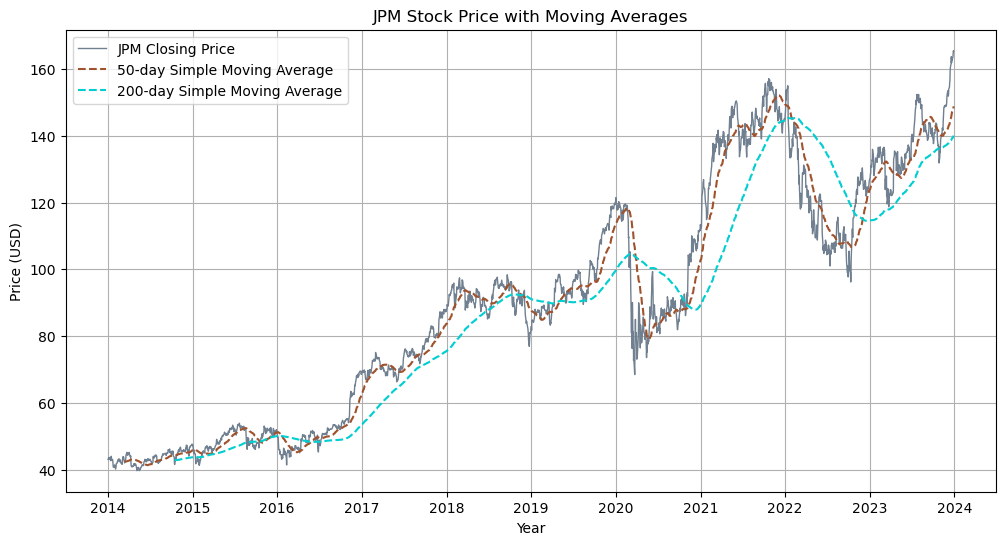

In [11]:
# plot MA
plt.figure(figsize=(12,6))
plt.plot(jpm['Close'], label='JPM Closing Price', color='slategrey', linewidth=1)
plt.plot(jpm['SMA_50'], label='50-day Simple Moving Average', color='sienna', linestyle='dashed')
plt.plot(jpm['SMA_200'], label='200-day Simple Moving Average', color='darkturquoise', linestyle='dashed')
plt.title('JPM Stock Price with Moving Averages')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Drop NaN values from making the rolling 
jpm.dropna(inplace=True)

In [13]:
# selecting useful features
features = ['Close', 'SMA_50', 'SMA_200', 'EMA_50', 'Daily Return', 'Volume_MA_10']
data = jpm[features]
# splitting train and test data
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]
print("Training Set Size:", train.shape)
print("Testing Set Size:", test.shape)

Training Set Size: (1853, 6)
Testing Set Size: (464, 6)


**Model 1: Linear Regression** – alr how accurate can this be?

Features: 1) Short-term (50 days) simple & exp. moving avgs, 2) Long-term (200 days) simple avg, 3) Daily Close Price percentage change, 4) volume moving avg.

In [15]:
features = ['SMA_50', 'SMA_200', 'EMA_50', 'Daily Return', 'Volume_MA_10']
X_train = train[features]
X_test = test[features]
y_train = train['Close']
y_test = test['Close']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
linreg_jpm = LinearRegression()
linreg_jpm.fit(X_train_scaled, y_train)

LinearRegression()

In [16]:
y_pred_linreg = linreg_jpm.predict(X_test_scaled)

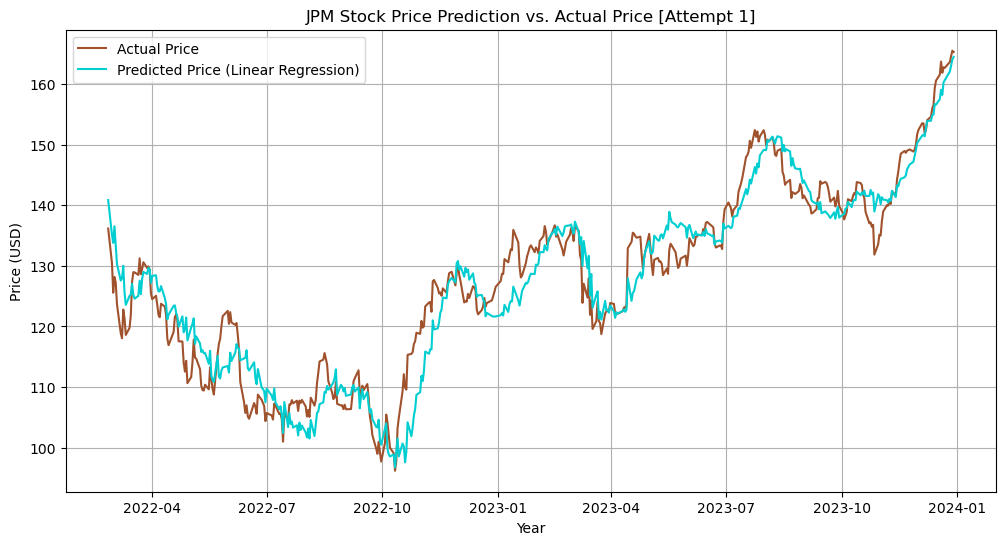

In [41]:
# Visualizing pred. vs actual
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual Price", color='sienna')
plt.plot(test.index, y_pred_linreg, label="Predicted Price (Linear Regression)", color='darkturquoise')
plt.title("JPM Stock Price Prediction vs. Actual Price [Attempt 1]")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Evaluate lin.reg model
rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
r2_linreg = r2_score(y_test, y_pred_linreg)
print(f"Root Mean Squared Error (RMSE): {rmse_linreg:.2f}")
print(f"R² Score: {r2_linreg:.4f}")

Root Mean Squared Error (RMSE): 4.37
R² Score: 0.9138


-JPM's stock price is often around 100-160 (USD)
=> error of 4.37 (USD) is about 2-3% deviation

-91.38% of the variance in the data explained by the model.

**Model 2:** Random Forest – uh woah can this be even better??

Same features as above for now

In [21]:
y_train = np.array(y_train).copy()

In [22]:
rf_jpm = RandomForestRegressor(n_estimators=100, random_state=42)
rf_jpm.fit(X_train_scaled, y_train)
y_pred_rf = rf_jpm.predict(X_test_scaled)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


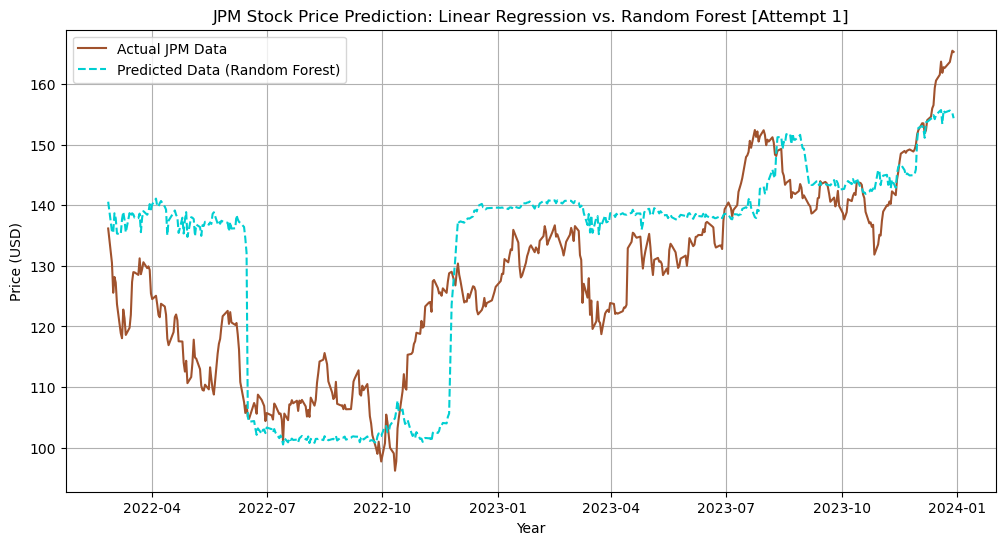

In [23]:
# RF Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual JPM Data", color='sienna', linewidth=1.5)
plt.plot(test.index, y_pred_rf, label="Predicted Data (Random Forest)", color='darkturquoise', linestyle='dashed', linewidth=1.5)
plt.title("JPM Stock Price Prediction: Linear Regression vs. Random Forest [Attempt 1]")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Evaluate RF model 2
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")

Random Forest RMSE: 11.33
Random Forest R² Score: 0.4204


Oh dear...

Let's try more trees just in case there's too little data

=> that might be causing the overfitting

In [26]:
rf_jpm2 = RandomForestRegressor(n_estimators=500, random_state=42).fit(X_train_scaled, y_train)
y_pred_rf2 = rf_jpm2.predict(X_test_scaled)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


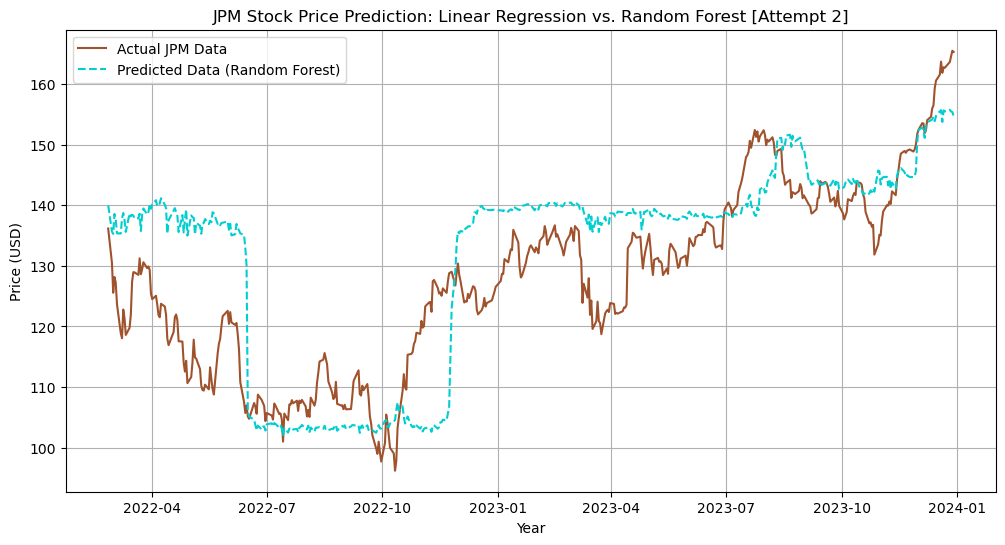

In [27]:
# RF Visualization 2
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual JPM Data", color='sienna', linewidth=1.5)
plt.plot(test.index, y_pred_rf2, label="Predicted Data (Random Forest)", color='darkturquoise', linestyle='dashed', linewidth=1.5)
plt.title("JPM Stock Price Prediction: Linear Regression vs. Random Forest [Attempt 2]")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Evaluate RF model 2
rmse_rf2 = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf2:.2f}")
print(f"Random Forest R² Score: {r2_rf2:.4f}")

Random Forest RMSE: 11.33
Random Forest R² Score: 0.4204


Same results–– interesting.

Okay apparently max_depth controls the amount of branch layers

=> so if we lower it, it should keep it from overanalyzing noise

=> less attention to noise hopefully means more accurate model

In [31]:
rf_jpm3 = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42).fit(X_train_scaled, y_train)
y_pred_rf3 = rf_jpm2.predict(X_test_scaled)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


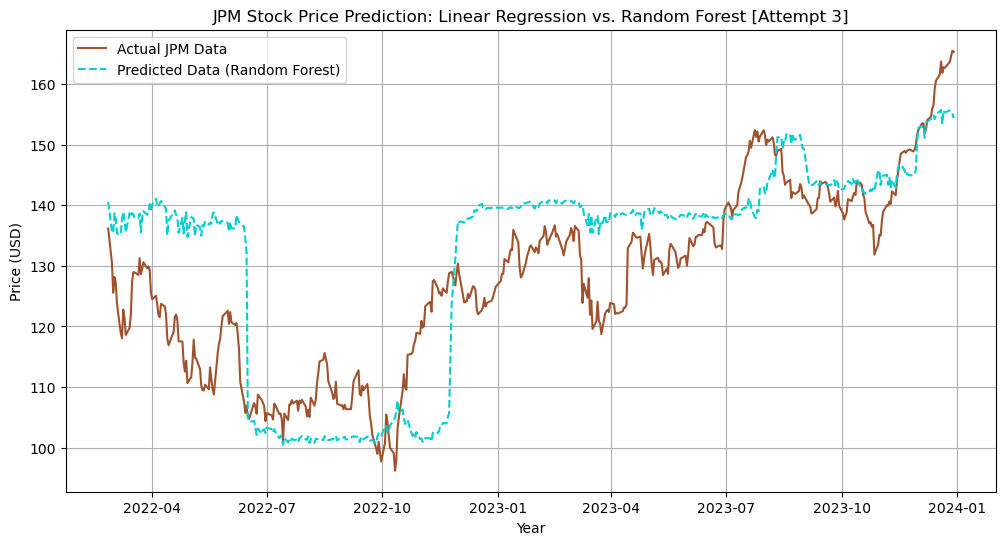

In [32]:
# RF Visualization 3
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual JPM Data", color='sienna', linewidth=1.5)
plt.plot(test.index, y_pred_rf, label="Predicted Data (Random Forest)", color='darkturquoise', linestyle='dashed', linewidth=1.5)
plt.title("JPM Stock Price Prediction: Linear Regression vs. Random Forest [Attempt 3]")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluate RF model 3
rmse_rf3 = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf3 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf3:.2f}")
print(f"Random Forest R² Score: {r2_rf3:.4f}")

Random Forest RMSE: 11.33
Random Forest R² Score: 0.4204


Yippee same thing again, from: nestimators 100 & 500, max_depth 5 & 3 & 1

**What probably happened (Learnings):**

Random Forest initially stood attractive because it groups multiple patterns, while Linear Regression numerically averages a trendline. But it's not as effective here despite some tries.

Because Random Forest tries to identify patterns, it seems to overvalue significant events. Looking at how it recreated the Grand Canyon, with the nosedive in 2022-07 and the skyrocket in 2022-12, it's probably overemphasizing past drops and copy-pasting them; so hmm, too much macro–– too little micro. 

But well–– if it's copy-pasting patterns, then it's probably more accurate with categories.

=> probably more accurate with predicting direction–– just not amplitude

=> Okay, is there a way to evaluate the directional accuracy?